<a href="https://colab.research.google.com/github/gohzhihwee/stuffs/blob/main/portfolio_crypto_ZH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -U kaleido

The following program used to calculate asset and portfolio statistics was created by Steven Medvetz (https://github.com/StevenMedvetz/stock-analysis/tree/main). I use this program to generate plots of the closing prices as well as calculate the mean return and standard deviation from the mean for each stock in the portfolio, as well as the correlation and covariance matrices between the stocks in the portfolio. Subsequently, I write additional functions to calculate the skewness and kurtosis for each stock as well as the portfolio. As this is a cryptocurrency portfolio notebook, all stock tickers are of cryptocurrencies. Data is taken from the Yahoo Finance website 'yfinance'.

In [2]:
import numpy as np
import yfinance as yf
from datetime import datetime
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import random
pio.renderers.default = "png"

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
class Asset:
    def __init__(self, ticker, start_date, end_date = datetime.today().strftime('%Y-%m-%d')):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date

    def get_data(self):
        df = yf.download(self.ticker, start = self.start_date, end = self.end_date)
        return df

    def simple_returns(self, adj = False, cum = False):
        df = self.get_data()
        if adj:
            simple_returns = df["Adj Close"].pct_change().dropna()
        else:
            simple_returns = df["Close"].pct_change().dropna()
        if cum:
            simple_returns = (1 + simple_returns).cumprod() - 1
        return simple_returns

    def log_returns(self, adj = False, cum = False):
        simple_returns = self.simple_returns(adj, cum)
        log_returns = np.log(1+simple_returns)
        return log_returns

    def std(self, adj = False, crypto = False):
        returns = self.simple_returns(adj).mul(100)
        if crypto:
            trading_days = 365
        else:
            trading_days  = 252
        std = returns.describe().T.loc["std"]
        std = std*np.sqrt(trading_days)
        return std

    def mean_return(self, adj = False, crypto = False, template = 'plotly_dark'):
        returns = self.simple_returns(adj).mul(100)
        if crypto:
            trading_days = 365
        else:
            trading_days  = 252
        mean = returns.describe().T.loc["mean"]
        mean = mean*trading_days # Multiply by number of trading days
        return mean

    def returns_plot(self, adj = False, cum = False, log = False, template = 'plotly_dark'):
        returns = self.simple_returns(adj, cum).mul(100)
        if log:
            returns = self.log_returns(adj, cum).mul(100)
        try:
            returns = returns.to_frame()
        except:
            pass

        returns = returns.rename(columns={'Close': 'Returns'})
        fig = px.line(returns, template = template)
        fig.update_traces(hovertemplate='%{y:.2f}%')
        fig.update_layout(
            showlegend = True,
            legend = dict(title = None, font = dict(size = 16)),
            title={
                'y':0.95,
                'x':0.5,
                'text': f"{self.ticker} Daily Returns",
                'font': {'size': 24},

                'xanchor': 'center',
                'yanchor': 'top'},
            hovermode = "x unified",
            xaxis_title = "Date",
            yaxis_title = "% Returns")

        fig.show()
        return returns

    def close_plot(self, adj = False, normalize = False, template = 'plotly_dark'):
        df = self.get_data()

        if adj:
            df["CLose"] = df["Adj Close"]
            title = f"{self.ticker} Adjusted Closing Price"
        else:
            title = f"{self.ticker} Closing Price"

        if normalize:
            df["Close"] = df["Close"].div(df["Close"].iloc[0]) #Normalizes data
            fig = px.line(df["Close"],
                          x = df.index,
                          y = df["Close"],
                          title = "Normalized " + title,
                          template = template) # Plotting Normalized closing data
            fig.update_traces(hovertemplate='Price: $%{y}')
            fig.update_layout(
                legend = dict(title = None, font = dict(size = 16)),
                title={
                'y':0.9,
                'x':0.5,
                'font': {'size': 24},
                'xanchor': 'center',
                'yanchor': 'top'},
                hovermode = "x unified",
                xaxis_title = "Date",
                yaxis_title = "Normalized " + title + " (USD)"
                )
            fig.show()
        else:

            fig = px.line(df["Close"],
                          x = df.index,
                          y = df["Close"],
                          title = title,
                          template = template) # Plotting Normalized closing data
            fig.update_traces(hovertemplate='Price: $%{y}')
            fig.update_layout(
                legend = dict(title = None, font = dict(size = 16)),
                title={
                'y':0.9,
                'x':0.5,
                'font': {'size': 24},
                'xanchor': 'center',
                'yanchor': 'top'},
                hovermode = "x unified",
                xaxis_title = "Date",
                yaxis_title = "Closing Price (USD)"
                )
            fig.show()


    def candlestick(self, sma1 = 0, sma2 = 0, template = 'plotly_dark'):

        ticker = Asset(self.ticker, self.start_date)
        df = ticker.get_data()

        fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02, row_heights=[0.7, 0.3])
        fig.add_trace(go.Candlestick(x=df.index,
                                      open=df['Open'],
                                      high=df['High'],
                                      low=df['Low'],
                                      close=df['Close'],
                                      name='candlestick'),

                      row=1, col=1)
        fig.update_traces(increasing_line_width = 1.5,
                          decreasing_line_width = 1.5
                         )
        if sma1 > 0:
            fig.add_trace(go.Scatter(x=df.index, y=df['Close'].rolling(window=sma1).mean(),
                                      name=f'{sma1}-day moving average', line=dict(color='lightblue', width = 1)),
                          row=1, col=1)
        if sma2 > 0:
            fig.add_trace(go.Scatter(x=df.index, y=df['Close'].rolling(window=sma2).mean(),
                                      name=f'{sma2}-day moving average', line=dict(color='red', width = 1)),
                          row=1, col=1)

        fig.add_trace(go.Bar(x=df.index,
                             y=df['Volume'],
                             name='volume'),
                      row=2, col=1)

        fig.update_layout(
                          title={
                          'text': f'{self.ticker} Candlestick Chart with Volume',
                          'y':0.9,
                          'x':0.5,
                          'font': {'size': 24},
                          'xanchor': 'center',
                          'yanchor': 'top',},
                          xaxis_rangeslider_visible=False,
                          xaxis_title='Date',
                          yaxis_title='Price (USD)',
                          hovermode = "x unified",
                          bargap=0,
                          bargroupgap=0,
                          template = template)
        fig.update_xaxes(title_text='', row=1, col=1, showgrid=False)
        fig.update_xaxes(title='Date', row=2, col=1)
        fig.update_yaxes(title='Volume',row=2,col=1)

        fig.show()

In [4]:
class Portfolio:
    def __init__(self, assets, start_date, weights = None, end_date = datetime.today().strftime('%Y-%m-%d')):
        self.assets = assets
        self.start_date = start_date
        self.end_date = end_date

        if weights is not None:
            self.weights = np.array(weights)
        else:
            self.weights = self.generate_random_weights()
    def generate_random_weights(self):
    # Generate random weights that add up to 1 and round to 1 digit
        weights = [round(random.random(), 1) for _ in range(len(self.assets))]
        total_weight = sum(weights)
        weights = np.array([round(weight / total_weight, 1) for weight in weights])
        print(weights)
        return weights



    # Data gather using yfinance
    def get_data(self):
        df = yf.download(self.assets, start = self.start_date, end = self.end_date)
        return df

    # Plot the closing price data
    def close_plot(self, adj = False, normalize = False, template = 'plotly_dark'):
        df = self.get_data()
        if adj:
            close = df.loc[:,"Adj Close"].copy()
            title = "Adjusted Closing Prices"
        else:
            close = df.loc[:,"Close"].copy()
            title = "Closing Prices"

        if normalize:
            normclose = close.div(close.iloc[0]) #Normalizes data

            normclose = normclose.to_frame()
            fig = px.line(normclose,
                          x = normclose.index,
                          y = normclose.columns,
                          title = "Normalized " + title,
                          template = template) # Plotting Normalized closing data
            fig.update_traces(hovertemplate='%{y}')
            fig.update_layout(
                legend = dict(title = None, font = dict(size = 16)),
                title={
                'y':0.9,
                'x':0.5,
                'font': {'size': 24},
                'xanchor': 'center',
                'yanchor': 'top'},
                hovermode = "x unified",
                xaxis_title = "Date",
                yaxis_title = "Normalized " + title + " (USD)"
                )
            fig.show()
        else:


            fig = px.line(close,
                          x = close.index,
                          y = close.columns,
                          title = title,
                          template = template) # Plotting Normalized closing data
            fig.update_traces(hovertemplate='%{y}')
            fig.update_layout(
                legend = dict(title = None, font = dict(size = 16)),
                title={
                'y':0.9,
                'x':0.5,
                'font': {'size': 24},
                'xanchor': 'center',
                'yanchor': 'top'},
                hovermode = "x unified",
                xaxis_title = "Date",
                yaxis_title = title +  " (USD)"
                )
            fig.show()


    def simple_returns(self, adj = False, cum = False):
        df = self.get_data()
        if adj:
            simple_returns = df["Adj Close"].pct_change().dropna()
        else:
            simple_returns = df["Close"].pct_change().dropna()
        if cum:
            simple_returns = (1 + simple_returns).cumprod() - 1
        return simple_returns

    def log_returns(self, adj = False, cum = False):
        simple_returns = self.simple_returns(adj, cum)
        log_returns = np.log(1+simple_returns)
        return log_returns


    def portfolio_returns(self, adj = False, cum = False):
        returns = self.simple_returns(adj, cum)
        portfolio_returns = (returns*self.weights).sum(axis=1)
        return portfolio_returns

    def returns_plot(self, port = False, benchmark = False, adj = False, cum = False, log = False, template = 'plotly_dark'):
        returns = self.simple_returns(adj, cum).mul(100)
        if log:
            returns = self.log_returns(adj, cum).mul(100)
        fig = px.line(returns, template = template)
        fig.update_traces(hovertemplate='%{y}')
        fig.update_layout(
            legend = dict(title = None, font = dict(size = 16)),
            title={
                'y':0.95,
                'x':0.5,
                'text': "Asset Returns",
                'font': {'size': 24},
                'xanchor': 'center',
                'yanchor': 'top'},
            hovermode = "x unified",
            xaxis_title = "Date",
            yaxis_title = "% Returns")

        if port:
            portfolio_returns = self.portfolio_returns(adj, cum)
            fig = px.line(portfolio_returns, template = template)
            fig.update_traces(name = 'Returns',hovertemplate='%{y}')
            fig.update_layout(
                legend = dict(title = None, font = dict(size = 16)),
                title={
                    'y':0.95,
                    'x':0.5,
                    'text': "Portfolio Returns",
                    'font': {'size': 24},
                    'xanchor': 'center',
                    'yanchor': 'top'},
                hovermode = "x unified",
                xaxis_title = "Date",
                yaxis_title = "% Returns")

        fig.show()

    def cov_matrix(self, plot = False, cum = False, template = 'plotly_dark'):
        returns = self.simple_returns()
        if cum:
            returns = self.simple_returns(cum)
        cov_matrix = returns.cov()

        if plot:
            fig = px.imshow(cov_matrix, text_auto=True, color_continuous_scale='tempo', template = template, title = "Covariance Matrix")
            fig.update_layout(
                legend = dict(title = None),
                title={
                'y':0.95,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'}
                )
            fig.show()
        return cov_matrix

    def corr_matrix(self, plot = False, cum = False, template = 'plotly_dark'):
        returns = self.simple_returns()
        if cum:
            returns = self.simple_returns(cum)
        corr_matrix = returns.corr()
        if plot:
            fig = px.imshow(corr_matrix, text_auto=True, color_continuous_scale='tempo', template = template, title = "Correlation Matrix")
            fig.update_layout(
                legend = dict(title = None),
                title={
                'y':0.95,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'}
                )
            fig.show()
        return corr_matrix

        #Standard Deviation of Portfolio w/ Optional Crypto Arg
    def port_std(self, crypto = False):
        if crypto:
            trading_days = 365
        else:
            trading_days  = 252

        cov_matrix = self.cov_matrix()
        port_variance = np.dot(self.weights.T, np.dot(cov_matrix, self.weights))
        port_std = np.sqrt(port_variance) * np.sqrt(trading_days)


        return port_std

    def risk_return(self, adj = False, crypto = False, template = 'plotly_dark'):
        returns = self.simple_returns(adj).mul(100)
        if crypto:
            trading_days = 365
        else:
            trading_days  = 252
        summary = returns.describe().T.loc[:,["mean","std"]]
        summary["mean"] = round(summary["mean"]*trading_days,2) # Multiply by number of trading days
        summary["std"]  = round(summary["std"]*np.sqrt(trading_days),2)
        summary.rename(columns = {'mean':'% Return', 'std':'Risk'}, inplace = True)
        fig = px.scatter(summary,
                         x = 'Risk',
                         y = '% Return',
                         title = "Annual Risk / Return",
                         text = summary.index,
                         template = template)
        fig.update_traces(hovertemplate='Risk: %{x}<br>Return: %{y}')
        fig.update_traces(marker={'size': 15},
                          textposition='top center',
                          hoverlabel=dict(font=dict(size=15) ))
        fig.update_layout(
            legend = dict(title = None),
            title={
            'y':0.9,
            'x':0.5,
            'font': {'size': 24},
            'xanchor': 'center',
            'yanchor': 'top',},
            xaxis = dict(title = dict(font = dict(size = 20))),
            yaxis = dict(title = dict(font = dict(size = 20)))
            )
        fig.show()

    def pie_plot(self, template = 'plotly_dark'):
        data = pd.DataFrame({"Assets": self.assets,
                             "Weights": self.weights})
        fig=go.Figure(go.Pie(labels=data['Assets'],
                                 values=data['Weights'],
                                 name = "",
                                 textinfo = 'label + percent'))
        fig.update_layout(template = template)
        fig.update_traces(hovertemplate='%{label}: %{percent}')
        fig.show()

In [5]:
tickers = ['DAI-USD', 'USDT-USD', 'BNB-USD', 'SOL-USD', 'BTC-USD', 'ETH-USD', 'DOT-USD', 'ADA-USD', 'DOGE-USD', 'XRP-USD']
weights = [0.1 for i in range(len(tickers))]
start_date = '2022-02-10'
pf = Portfolio(tickers, start_date, weights)

[*********************100%%**********************]  10 of 10 completed


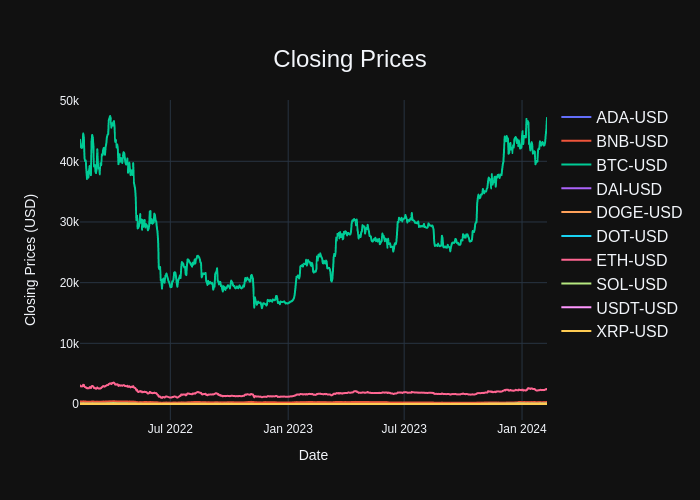

In [6]:
pf.close_plot()

In [7]:
pf.corr_matrix()

[*********************100%%**********************]  10 of 10 completed


Ticker,ADA-USD,BNB-USD,BTC-USD,DAI-USD,DOGE-USD,DOT-USD,ETH-USD,SOL-USD,USDT-USD,XRP-USD
Ticker,,,,,,,,,,
ADA-USD,1.000000,0.710290,0.747567,0.175795,0.642634,0.821411,0.757010,0.729034,0.115547,0.684201
BNB-USD,0.710290,1.000000,0.750992,0.147931,0.607137,0.731338,0.768088,0.674575,0.110686,0.554267
BTC-USD,0.747567,0.750992,1.000000,0.151530,0.629065,0.749891,0.863894,0.727709,0.108579,0.570436
DAI-USD,0.175795,0.147931,0.151530,1.000000,0.098164,0.160754,0.126700,0.136988,-0.409023,0.103645
DOGE-USD,0.642634,0.607137,0.629065,0.098164,1.000000,0.634593,0.652929,0.568552,0.100238,0.499445
DOT-USD,0.821411,0.731338,0.749891,0.160754,0.634593,1.000000,0.774342,0.762216,0.158384,0.588820
ETH-USD,0.757010,0.768088,0.863894,0.126700,0.652929,0.774342,1.000000,0.734825,0.129545,0.604486
SOL-USD,0.729034,0.674575,0.727709,0.136988,0.568552,0.762216,0.734825,1.000000,0.158406,0.569021
USDT-USD,0.115547,0.110686,0.108579,-0.409023,0.100238,0.158384,0.129545,0.158406,1.000000,0.100390


In [8]:
pf.cov_matrix()

[*********************100%%**********************]  10 of 10 completed


Ticker,ADA-USD,BNB-USD,BTC-USD,DAI-USD,DOGE-USD,DOT-USD,ETH-USD,SOL-USD,USDT-USD,XRP-USD
Ticker,,,,,,,,,,
ADA-USD,0.001712,0.000887,0.000877,9.632682e-06,0.001214,0.001391,0.001114,0.001705,1.845167e-06,0.001295
BNB-USD,0.000887,0.000911,0.000642,5.911969e-06,0.000837,0.000903,0.000824,0.001150,1.289150e-06,0.000765
BTC-USD,0.000877,0.000642,0.000803,5.686630e-06,0.000814,0.000870,0.000871,0.001165,1.187516e-06,0.000740
DAI-USD,0.000010,0.000006,0.000006,1.753279e-06,0.000006,0.000009,0.000006,0.000010,-2.089955e-07,0.000006
DOGE-USD,0.001214,0.000837,0.000814,5.934453e-06,0.002085,0.001185,0.001060,0.001467,1.766041e-06,0.001043
DOT-USD,0.001391,0.000903,0.000870,8.709207e-06,0.001185,0.001674,0.001127,0.001762,2.500719e-06,0.001102
ETH-USD,0.001114,0.000824,0.000871,5.965983e-06,0.001060,0.001127,0.001265,0.001476,1.777722e-06,0.000984
SOL-USD,0.001705,0.001150,0.001165,1.024852e-05,0.001467,0.001762,0.001476,0.003192,3.453733e-06,0.001471
USDT-USD,0.000002,0.000001,0.000001,-2.089955e-07,0.000002,0.000003,0.000002,0.000003,1.489114e-07,0.000002


In [9]:
asset_dict = {}
mret_dict = {}
sd_dict = {}
for tf in tickers:
  asset_dict[f'{tf}'] = Asset(tf, start_date)
  mret_dict[f'{tf}'] = asset_dict[f'{tf}'].mean_return()
  sd_dict[f'{tf}'] = asset_dict[f'{tf}'].std()
mret_dict

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

{'DAI-USD': 0.06535084026441768,
 'USDT-USD': -0.006280907278703678,
 'BNB-USD': 3.053313917806176,
 'SOL-USD': 41.07060567327002,
 'BTC-USD': 12.891918786441327,
 'ETH-USD': 8.627925404516493,
 'DOT-USD': -15.222874370502474,
 'ADA-USD': -4.734505286248624,
 'DOGE-USD': 4.108292931188342,
 'XRP-USD': 7.599603442095542}

In [10]:
sd_dict

{'DAI-USD': 2.101966288732528,
 'USDT-USD': 0.6125820786383073,
 'BNB-USD': 47.91243544717616,
 'SOL-USD': 89.69199614249169,
 'BTC-USD': 44.991475358064335,
 'ETH-USD': 56.45196451100499,
 'DOT-USD': 64.95168475965568,
 'ADA-USD': 65.69228022801893,
 'DOGE-USD': 72.47785437448252,
 'XRP-USD': 72.63198847279804}

In [11]:
#Narrow down stock selection to top 3 stocks with highest mean returns during
#this period (the assumption is that the portfolio was created on 2024-01-10)
x=list(mret_dict.values())
top3 = []
x.sort(reverse=True)
x=x[:3]
for i in x:
    for j in mret_dict.keys():
        if(mret_dict[j]==i):
            print(str(j)+" : "+str(mret_dict[j]))
            top3.append(j)

SOL-USD : 41.07060567327002
BTC-USD : 12.891918786441327
ETH-USD : 8.627925404516493


In [12]:
#Now redo portfolio to only include top 3 cryptocurrency shares
weights = [x[e]/sum(x) for e in range(len(x))]
start_date = '2024-01-10'
pf = Portfolio(top3, start_date, weights)

In [13]:
weights

[0.6561800684027836, 0.20597261745852083, 0.1378473141386956]

[*********************100%%**********************]  3 of 3 completed


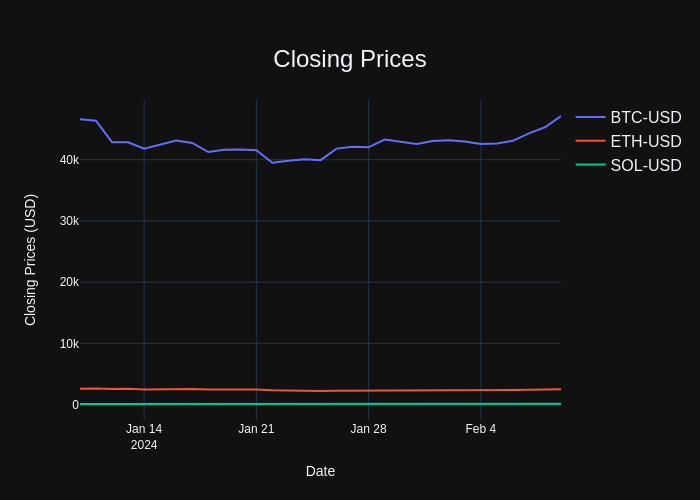

In [14]:
pf.close_plot()

In [15]:
pf.corr_matrix()

[*********************100%%**********************]  3 of 3 completed


Ticker,BTC-USD,ETH-USD,SOL-USD
Ticker,,,
BTC-USD,1.000000,0.767674,0.824146
ETH-USD,0.767674,1.000000,0.681035
SOL-USD,0.824146,0.681035,1.000000


In [16]:
pf.cov_matrix()

[*********************100%%**********************]  3 of 3 completed


Ticker,BTC-USD,ETH-USD,SOL-USD
Ticker,,,
BTC-USD,0.000601,0.000426,0.000791
ETH-USD,0.000426,0.000514,0.000604
SOL-USD,0.000791,0.000604,0.001533


In [17]:
sdev_pf = pf.port_std()
sdev_pf

[*********************100%%**********************]  3 of 3 completed


0.38953724102070814

In [18]:
returns = pf.portfolio_returns()
returns

[*********************100%%**********************]  3 of 3 completed


Date
2024-01-11   -0.003524
2024-01-12   -0.068528
2024-01-13    0.010114
2024-01-14   -0.026664
2024-01-15    0.015018
2024-01-16    0.020761
2024-01-17   -0.004726
2024-01-18   -0.038280
2024-01-19    0.006279
2024-01-20   -0.002108
2024-01-21   -0.005758
2024-01-22   -0.055169
2024-01-23    0.000439
2024-01-24    0.010449
2024-01-25   -0.006670
2024-01-26    0.044348
2024-01-27    0.007386
2024-01-28    0.000313
2024-01-29    0.033103
2024-01-30   -0.002777
2024-01-31   -0.017132
2024-02-01    0.010682
2024-02-02    0.005708
2024-02-03   -0.007527
2024-02-04   -0.010204
2024-02-05    0.002101
2024-02-06    0.015015
2024-02-07    0.029123
2024-02-08    0.016699
2024-02-09    0.038051
dtype: float64

In [19]:
total_return_portfolio = sum(returns)
total_return_portfolio

0.016522271542963308

In [20]:
mean_ret = total_return_portfolio/len(returns)
mean_ret

0.0005507423847654436

In [21]:
asset_dict = {}
mret_dict = {}
sd_dict = {}
for tf in top3:
  asset_dict[f'{tf}'] = Asset(tf, start_date)
  mret_dict[f'{tf}'] = asset_dict[f'{tf}'].mean_return()
  sd_dict[f'{tf}'] = asset_dict[f'{tf}'].std()
mret_dict

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


{'SOL-USD': 58.362165136030406,
 'BTC-USD': 16.739068818606427,
 'ETH-USD': -25.004308830812672}

In [22]:
sd_dict

{'SOL-USD': 62.15690521453599,
 'BTC-USD': 38.90070083258901,
 'ETH-USD': 35.984514622883786}

In [23]:
#Calculate Fisher-Pearson sample skewness coefficient and kurtosis for each
#stock's returns
return_dict = {}
sum_ctr = 0
kurt_ctr = 0
skew_dict, kurt_dict = {}, {}
for tf in top3:
  mean = 0
  return_dict[f'{tf}'] = asset_dict[f'{tf}'].simple_returns()
  mean = sum(return_dict[f'{tf}'])/len(return_dict[f'{tf}'])
  for j in range(len(return_dict[f'{tf}'])):
    sum_ctr += (return_dict[f'{tf}'][j] - mean)**3
    kurt_ctr += (return_dict[f'{tf}'][j] - mean)**4
  skew_dict[f'{tf}'] = np.sqrt(len(return_dict[f'{tf}'])*(len(return_dict[f'{tf}']) - 1))/((len(return_dict[f'{tf}']) - 2)) *(sum_ctr/(len(return_dict[f'{tf}'])*(sd_dict[f'{tf}']**3)))
  kurt_dict[f'{tf}'] = kurt_ctr/(len(return_dict[f'{tf}'])*(sd_dict[f'{tf}']**4))
skew_dict

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


{'SOL-USD': -1.3871069620453764e-10,
 'BTC-USD': -8.054465207049067e-10,
 'ETH-USD': -1.1689914534306009e-09}

In [24]:
kurt_dict

{'SOL-USD': 4.11286982328895e-13,
 'BTC-USD': 3.4270035703793334e-12,
 'ETH-USD': 5.095104498505494e-12}

In [25]:
#Calculate entire portfolio return skewness and kurtosis
sum_returns = 0
sum_ctr, kurt_ctr = 0, 0
for tf in top3:
  sum_returns += return_dict[f'{tf}']
mean = sum(sum_returns)/len(sum_returns)
for j in range(len(sum_returns)):
  sum_ctr += (sum_returns[j] - mean)**3
  kurt_ctr += (sum_returns[j] - mean)**4
skew = np.sqrt(len(sum_returns)*(len(sum_returns) - 1))/((len(sum_returns) - 2)) * (sum_ctr/(len(sum_returns)*(sdev_pf**3)))
kurt = sum_ctr/(len(sum_returns)*(sdev_pf**4))

In [26]:
kurt

-0.01640887154640466

In [27]:
skew

-0.006733320611162275